In [2]:
import pandas as pd
import numpy as np
import pickle
import keras
from keras.models import Model, Sequential
from keras.applications import resnet50, vgg16
from keras.preprocessing import image
from sklearn.model_selection import train_test_split, KFold
from keras import backend as K
from keras.layers import *
from keras import layers
from keras.callbacks import EarlyStopping, Callback
from keras.regularizers import l1, l2
# from skimage.io import imread
import matplotlib.pyplot as plt
import sklearn
import lightgbm as lgb
import time
import tensorflow as tf
import json

K.set_image_data_format('channels_last')

path = '../Data/'

# class_emb = pd.read_csv(path + '/DatasetA_train_20180813/class_wordembeddings.txt', 
#                         index_col = 0, sep = ' ', header = None)
# class_emb.index.name = 'class_name'
# # class_emb_vec = pd.DataFrame(index = class_emb.index)
# class_emb = class_emb.apply(lambda s: np.array([float(x) for x in s]), axis = 1)

# class_id_to_name = pd.read_csv(path + '/DatasetA_train_20180813/label_list.txt', 
#                                index_col = 'class_name', sep = '\t', header = None, names = ['class_id', 'class_name'])

# attr_list = pd.read_csv(path + '/DatasetA_train_20180813/attribute_list.txt', index_col = 0, sep = '\t', header = None)

# attributes_per_class = pd.read_csv(path + '/DatasetA_train_20180813/attributes_per_class.txt', 
#                                    index_col = 0, sep = '\t', header = None)
# attributes_per_class.index.name = 'class_id'
# attributes_per_class = attributes_per_class.apply(lambda s: np.array([float(x) for x in s]), axis = 1)

# class_id_emb_attr = class_id_to_name.copy()
# class_id_emb_attr['emb'] = class_emb
# class_id_emb_attr.reset_index(inplace = True)
# class_id_emb_attr.set_index('class_id', inplace = True)
# class_id_emb_attr['attr'] = attributes_per_class

# with open(path + 'class_id_emb_attr.pickle', 'wb+') as handle:
#     pickle.dump(class_id_emb_attr, handle)
def read_image(imag_path, image_id):
    img = image.load_img(imag_path + image_id)
    img = image.img_to_array(img)
#     img= vgg16.preprocess_input(image.img_to_array(img))
    return img

In [13]:
# attr_list = pd.read_csv(path + '/DatasetA_train_20180813/attribute_list.txt', index_col = 0, sep = '\t', header = None)
# attr_list = attr_list.apply(lambda s: s[1].replace(' ', '_'), axis = 1)
# attributes_per_class = pd.read_csv(path + '/DatasetA_train_20180813/attributes_per_class.txt', 
#                                    index_col = 0, sep = '\t', header = None)
# adj_graph
# attr = np.array(list(class_id_emb_attr['attr']))
# adj_graph = sklearn.metrics.pairwise.pairwise_distances(attr, metric = 'l2')
# np.argsort(adj_graph[0])
# adj_graph
# class_id_emb_attr['attr'].values
with open(path + '../zero-shot-gcn/data/imagenet_graph.pkl', 'rb') as handle:
    imagenet_graph = pickle.load(handle)
with open(path + '../zero-shot-gcn/data/list/invdict_wordntext.json', 'r') as fp:
    words = json.load(fp)
class_names = class_id_emb_attr['class_name'].values
class_name_to_id = dict([(c, i) for i, c in enumerate(class_names)])
class_wns = [[]] * class_names.shape[0]
class_neighbor_wns = [[]] * class_names.shape[0]
words_array = np.asarray(words)
for i, word in enumerate(words):
    for w in word.split(', '):
        if w in class_name_to_id:
#             print (class_name_to_id[w], i)
            if len(class_wns[class_name_to_id[w]]) == 0:
                class_wns[class_name_to_id[w]] = []
            class_wns[class_name_to_id[w]].append(i)
#             print (class_wns)
            if len(class_neighbor_wns[class_name_to_id[w]]) == 0:
                class_neighbor_wns[class_name_to_id[w]] = []
            class_neighbor_wns[class_name_to_id[w]].extend(imagenet_graph[i])
#             print (word, words_array[imagenet_graph[i]])
#             print (i, w)
#             if w not in class_dict:
#                 class_dict[w] = 0
#             class_dict[w] += 1
# print (class_wns)
adj_graph = scipy.eye(class_names.shape[0])
for i, neighbor_wns in enumerate(class_neighbor_wns):
    for j, wns in enumerate(class_wns):
        if i == j:
            continue
        for neighbor in neighbor_wns:
            if neighbor in wns:
                adj_graph[i, j] = 1
                adj_graph[j, i] = 1
#                 print(class_names[i], class_names[j])
                break
adj_graph

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [14]:
sum(adj_graph == 1)

array([1, 1, 2, 1, 1, 1, 7, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 3, 1, 1,
       1, 1, 1, 3, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 3, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1,
       2, 1, 1, 2, 1, 1, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1,
       8, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2])

In [3]:
# train_data = pd.read_csv(path + '/DatasetA_train_20180813/train.txt', index_col = 'class_id', 
#                          sep = '\t', header = None, names = ['image_id', 'class_id'])
# train_data = train_data.merge(class_id_emb_attr, how = 'left', on = 'class_id')

# imag_path = path + r'/DatasetA_train_20180813/train/'

# train_data['img'] = train_data['image_id'].apply(lambda id: read_image(id))

# train_data.reset_index(inplace = True)
with open(path + 'class_id_emb_attr.pickle', 'rb') as handle:
    class_id_emb_attr = pickle.load(handle)
class_id_emb_attr.reset_index(inplace = True)    
# with open(path + '/train_img.pickle', 'rb') as handle:
with open(path + '/model_sub/6_12_24_16_ini64_growth16_02962/train_data_2018_09_13_13_42_21.pickle', 'rb') as handle:
    train_data = pickle.load(handle)

In [34]:
with open(path + '/model_sub/6_12_24_16_ini64_growth16_02962/train_data_2018_09_13_13_42_21.pickle', 'wb') as handle:
    pickle.dump(train_data, handle)

In [7]:
fast_text =  pd.read_csv(path + '/FoundInFastText', 
                        index_col = 0, sep = ' ', header = None)
fast_text.index.name = 'class_name'
fast_text_df = pd.DataFrame(index = fast_text.index)
fast_text_df['emb'] = fast_text.apply(lambda s: np.array([float(x) for x in s])[:300], axis = 1)

train_data = train_data.merge(fast_text_df, how = 'left', on = 'class_name')

train_data['emb'] = train_data.apply(lambda s: np.hstack([s['emb_x'], s['emb_y']]), axis = 1)

class_id_emb_attr = class_id_emb_attr.merge(fast_text_df, how = 'left', on = 'class_name')
class_id_emb_attr['emb'] = class_id_emb_attr.apply(lambda s: np.hstack([s['emb_x'], s['emb_y']]), axis = 1)

In [191]:
train_data['emb'] = train_data['emb_y']
class_id_emb_attr['emb'] = class_id_emb_attr['emb_y']
train_data.head()

,class_id,image_id,class_name,emb_x,attr,img,target,preds,emb_y,emb
0,ZJL1,a6394b0f513290f4651cc46792e5ac86.jpeg,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ...","[[[20.0, 33.0, 7.0], [19.0, 32.0, 6.0], [22.0,...","[0.31291956, 0.06956485, 0.34872296, 0.0408261...","[0.00025839225, 1.3706162e-09, 4.1264666e-06, ...","[0.10102, 0.1569, -0.56942, 0.2555300000000000...","[0.10102, 0.1569, -0.56942, 0.2555300000000000..."
1,ZJL1,2fb89ef2ace869d3eb3bdd3afe184e1c.jpeg,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ...","[[[140.0, 45.0, 51.0], [144.0, 47.0, 54.0], [1...","[0.41405687, 0.0, 0.427736, 0.26566926, 0.0959...","[8.5285705e-05, 7.096223e-13, 2.6975644e-07, 0...","[0.10102, 0.1569, -0.56942, 0.2555300000000000...","[0.10102, 0.1569, -0.56942, 0.2555300000000000..."
2,ZJL1,eda9f3bef2bd8da038f6acbc8355fc25.jpeg,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ...","[[[81.0, 69.0, 21.0], [86.0, 74.0, 26.0], [85....","[0.47680357, 0.040604617, 0.39211324, 0.050536...","[4.0051538e-07, 2.7406824e-10, 0.0068722973, 1...","[0.10102, 0.1569, -0.56942, 0.2555300000000000...","[0.10102, 0.1569, -0.56942, 0.2555300000000000..."
3,ZJL1,7d93ef45972154aae150b4f9980a79c0.jpeg,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ...","[[[16.0, 14.0, 15.0], [18.0, 16.0, 17.0], [19....","[0.43787622, 0.2263094, 0.91177565, 0.37130383...","[4.4784274e-06, 6.633557e-15, 4.5222623e-07, 5...","[0.10102, 0.1569, -0.56942, 0.2555300000000000...","[0.10102, 0.1569, -0.56942, 0.2555300000000000..."
4,ZJL1,fb901b4f9a8e396c1d0155bccc5e5671.jpeg,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ...","[[[120.0, 124.0, 127.0], [89.0, 93.0, 96.0], [...","[0.09672487, 0.020393904, 0.0, 0.063967496, 0....","[1.1269757e-05, 1.5967199e-12, 0.00011251625, ...","[0.10102, 0.1569, -0.56942, 0.2555300000000000...","[0.10102, 0.1569, -0.56942, 0.2555300000000000..."


In [4]:
category = train_data['class_id'].unique()
category_dict = dict((category[i], i) for i in range(category.shape[0]))

# vgg_model = vgg16.VGG16(include_top=True, weights = None, input_shape=(64, 64, 3), classes = train_data['class_id'].unique().shape[0])


# with open(path + 'train_vgg16_img_div255.pickle', 'rb') as handle:
#     train_y = pickle.load(handle)

# input = Input(shape = (2048, ))
# dense = Dense(2048, activation="relu")(input)
# dense = Dropout(0.5)(dense)
# dense = Dense(2048, activation="relu")(input)
# dense = Dense(1024, activation="relu")(input)
# dense = Dense(category.shape[0], activation="softmax")(input)

# vgg_model = Model(input, dense)

# vgg_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])

# print (vgg_model.summary())

# train_image_feature_map = np.reshape(vgg_model.predict(train_data_part_img, verbose=  1), (train_data_part_length, -1))
# with open(path + 'train_vgg16_img_div255.pickle', 'wb+') as handle:
#     pickle.dump(train_y, handle)
# with open(path + 'train_vgg16_img_div255.pickle', 'rb') as handle:
#     train_image_feature_map = pickle.load(handle)
# train_data['target'] = list(train_image_feature_map)

def extract_array_from_series(s):
    return np.asarray(list(s))

class DenseNet:
    """
    """
    def __init__(self, cat_max, blocks, weight_decay, kernel_initializer, reduction, init_filters, growth_rate):
        self.cat_max = cat_max
        self.blocks = blocks
        self.weight_decay = weight_decay
        self.kernel_initializer = kernel_initializer
        self.model = self.small_densenet(
                classes = self.cat_max,
                blocks = self.blocks, 
                weight_decay = self.weight_decay, 
                kernel_initializer = self.kernel_initializer,
                init_filters = init_filters,
                reduction = reduction,
                growth_rate = growth_rate)

    def dense_block(self, x, blocks, name, weight_decay = 1e-4, kernel_initializer = 'he_normal', growth_rate = None):
        """A dense block.
        # Arguments
            x: input tensor.
            blocks: integer, the number of building blocks.
            name: string, block label.
        # Returns
            output tensor for the block.
        """
        for i in range(blocks):
            x = self.conv_block(x, growth_rate, name=name + '_block' + str(i + 1), 
                weight_decay = weight_decay,
                kernel_initializer = kernel_initializer)
        return x

    def transition_block(self, x, reduction, name, weight_decay = 1e-4, kernel_initializer = 'he_normal'):
        """A transition block.
        # Arguments
            x: input tensor.
            reduction: float, compression rate at transition layers.
            name: string, block label.
        # Returns
            output tensor for the block.
        """
        bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                    name=name + '_bn')(x)
        x = layers.Activation('relu', name=name + '_relu')(x)
        x = layers.Conv2D(int(K.int_shape(x)[bn_axis] * reduction), 1,
                        use_bias=False,
                        kernel_initializer = kernel_initializer,
                        kernel_regularizer = l2(weight_decay),
                        name=name + '_conv')(x)
        x = layers.AveragePooling2D(2, strides=2, name=name + '_pool')(x)
        return x

    def conv_block(self, x, growth_rate, name, weight_decay = 1e-4, kernel_initializer = 'he_normal'):
        """A building block for a dense block.
        # Arguments
            x: input tensor.
            growth_rate: float, growth rate at dense layers.
            name: string, block label.
        # Returns
            Output tensor for the block.
        """
        bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
        x1 = layers.BatchNormalization(axis=bn_axis,
                                    epsilon=1.001e-5,
                                    name=name + '_0_bn')(x)
        x1 = layers.Activation('relu', name=name + '_0_relu')(x1)
        x1 = layers.Conv2D(4 * growth_rate, 1,
                        use_bias=False,
                        kernel_initializer = kernel_initializer,
                        kernel_regularizer = l2(weight_decay),
                        name=name + '_1_conv')(x1)
        x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                    name=name + '_1_bn')(x1)
        x1 = layers.Activation('relu', name=name + '_1_relu')(x1)
        x1 = layers.Conv2D(growth_rate, 3,
                        padding='same',
                        use_bias=False,
                        kernel_initializer = kernel_initializer,
                        kernel_regularizer = l2(weight_decay),
                        name=name + '_2_conv')(x1)
        x = layers.Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])
        return x

    def small_densenet(self, classes = None, 
                       img_input_shape = (64, 64, 3), 
                       blocks = [6, 12, 24, 16], 
                       weight_decay = 1e-4, 
                       kernel_initializer = 'he_normal',
                       reduction = 0.5, 
                       init_filters = None, 
                       growth_rate = None):
        img_input = Input(shape = (img_input_shape))
#         x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(img_input)
#         x = layers.Conv2D(64, 3, strides=1, use_bias=False, 
#             kernel_initializer = kernel_initializer, 
#             kernel_regularizer = l2(weight_decay),
#             name='conv1/conv')(img_input)
#         x = layers.BatchNormalization(
#             axis=3, epsilon=1.001e-5, name='conv1/bn')(x)
#         x = layers.Activation('relu', name='conv1/relu')(x)
#         x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
#         x = layers.MaxPooling2D(3, strides=2, name='pool1')(x)
        
        x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(img_input)
        x = layers.Conv2D(init_filters, 3, strides=1, use_bias=False, 
            kernel_initializer = kernel_initializer, 
            kernel_regularizer = l2(weight_decay),
            name='conv1/conv')(x)
        x = layers.BatchNormalization(
            axis=3, epsilon=1.001e-5, name='conv1/bn')(x)
        x = layers.Activation('relu', name='conv1/relu')(x)
        x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
        x = layers.AveragePooling2D(3, strides=2, name='pool1')(x)
        
        for i, block in enumerate(blocks):
            scope_num_str = str(i + 2)
            x = self.dense_block(x, block, name='conv' + scope_num_str, 
                                 weight_decay = weight_decay, kernel_initializer = kernel_initializer, growth_rate = growth_rate)
            if i != len(blocks) - 1:
                x = self.transition_block(x, reduction, name='pool' + scope_num_str, 
                                          weight_decay = weight_decay, kernel_initializer = kernel_initializer)
        
        x = layers.BatchNormalization(
            axis=3, epsilon=1.001e-5, name='bn')(x)
        x = layers.Activation('relu', name='relu')(x)

        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        # x = Lambda(lambda x: x, name = 'densenet_features')(x)
        x = layers.Dense(classes, activation='softmax',
            kernel_initializer = kernel_initializer, 
#             kernel_regularizer = l2(weight_decay), 
            name='fc')(x)
        
        model = Model(img_input, x)
        print (model.summary())
        model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
        
        return model
# train_data = train_data[:1000]
train_img = extract_array_from_series(train_data['img'])
train_img = vgg16.preprocess_input(train_img)
OneHotEncoder = sklearn.preprocessing.OneHotEncoder()
train_target = train_data['class_id'].apply(lambda id: category_dict[id]).values
train_target = OneHotEncoder.fit_transform(np.reshape(train_target, (-1, 1))).toarray()

In [6]:
fold = 5
kf = KFold(n_splits=fold, shuffle=True)
num_fold = 0
batch_size = 256
# train_image_feature_map = np.reshape(vgg_model.predict(train_data_part_img, verbose=  1), (train_data_part_length, -1))
# with open(path + 'train_vgg16_img_div255.pickle', 'wb+') as handle:
#     pickle.dump(train_y, handle)
# with open(path + 'train_vgg16_img_div255.pickle', 'rb') as handle:
#     train_image_feature_map = pickle.load(handle)

for train_index, test_index in kf.split(train_img):
    train_part_img = train_img[train_index]
    validate_part_img = train_img[test_index]
    
    train_part_target = train_target[train_index]
    validate_part_target = train_target[test_index]
    
    print ('Train target nunique: ', np.unique(np.argwhere(train_part_target == 1)[:, 1]).shape[0], 
           'Validate target nuique: ', np.unique(np.argwhere(validate_part_target == 1)[:, 1]).shape[0])
#     model = vgg16.VGG16(include_top=True, weights = None, input_shape=(64, 64, 3), classes = category.shape[0])
#     model = resnet50.ResNet50(include_top=True, weights = None, input_shape=(224, 224, 3), classes = category.shape[0])
#     print (model.summary())
#     model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
    img_model = DenseNet(blocks = [2, 2, 2, 2], 
                                cat_max = train_target.shape[1],
                                weight_decay = 1e-4, 
                                kernel_initializer = 'glorot_normal',
                                reduction = 0.5) 
#     print (img_model.summary())
    # img_model = small_vgg(img_input_shape = (64, 64, 3), classes = train_target.shape[1])
#     datagen = keras.preprocessing.image.ImageDataGenerator(
# #             featurewise_center=True,
# #             featurewise_std_normalization=True,
#             rotation_range=45,
#             shear_range = 0.2,
#             zoom_range=0.2,
# #             width_shift_range=0.2,
# #             height_shift_range=0.2,
#             horizontal_flip=True)
#     datagen.fit(train_part_img)
#     h = img_model.model.fit_generator(datagen.flow(train_part_img, train_part_target, batch_size=batch_size), 
#                   validation_data=(validate_part_img, validate_part_target), 
#                   epochs=100, shuffle=True, verbose = 1, workers=1, use_multiprocessing=False, 
#                   callbacks=[EarlyStopping(monitor='val_categorical_accuracy', patience=25, verbose=0)],
#                   steps_per_epoch = train_part_img.shape[0]//batch_size,)
    h = img_model.model.fit(train_part_img, train_part_target, validation_data=(validate_part_img, validate_part_target), 
                  epochs=100, batch_size = 256, shuffle=True, verbose = 1, 
                  callbacks=[EarlyStopping(monitor='val_categorical_accuracy', patience=15, verbose=0)])
    break

Train target nunique:  190 Validate target nuique:  190
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 62, 62, 64)   1728        input_2[0][0]                    
__________________________________________________________________________________________________
conv2_block1_0_bn (BatchNormali (None, 62, 62, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv2_block1_0_relu (Activation (None, 62, 62, 64)   0           conv2_block1_0_bn[0][0]          
_____________________________________________________

Train on 30576 samples, validate on 7645 samples
Epoch 1/100
16128/30576 [==============>...............] - ETA: 2:11:36 - loss: 5.1581 - categorical_accuracy: 0.0287

KeyboardInterrupt: 

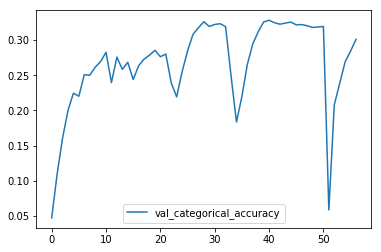

In [57]:
pd.DataFrame(h.history)[['val_categorical_accuracy']].plot()

In [11]:
def small_dnn(classes = None, 
                       img_input_shape = (64, 64, 3), 
                       blocks = [6, 12, 24, 16], 
                       weight_decay = 1e-4, 
                       kernel_initializer = 'he_normal',
                       reduction = 0.5):
    img_input = Input(shape = (img_input_shape))
    x = layers.Dense(classes, activation='softmax',
        kernel_initializer = kernel_initializer, 
#             kernel_regularizer = l2(weight_decay), 
        name='fc')(img_input)

    model = Model(img_input, x)
    print (model.summary())
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])

    return model

fold = 5
kf = KFold(n_splits=fold, shuffle=True)
num_fold = 0
batch_size = 256
train_image_feature_map = extract_array_from_series(train_data['target'])

for train_index, test_index in kf.split(train_img):
    train_part_img = train_image_feature_map[train_index]
    validate_part_img = train_image_feature_map[test_index]
    
    train_part_target = train_target[train_index]
    validate_part_target = train_target[test_index]
    
    print ('Train target nunique: ', np.unique(np.argwhere(train_part_target == 1)[:, 1]).shape[0], 
           'Validate target nuique: ', np.unique(np.argwhere(validate_part_target == 1)[:, 1]).shape[0])

    img_classifi_model = small_dnn(img_input_shape = (1024, ), 
                                classes = train_target.shape[1]) 
    
    h = img_classifi_model.fit(train_part_img, train_part_target, validation_data=(validate_part_img, validate_part_target), 
                  epochs=100, batch_size = 64, shuffle=True, verbose = 1, 
                  callbacks=[EarlyStopping(monitor='val_categorical_accuracy', patience=3, verbose=0)])
    break

Train target nunique:  190 Validate target nuique:  190
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
fc (Dense)                   (None, 190)               194750    
Total params: 194,750
Trainable params: 194,750
Non-trainable params: 0
_________________________________________________________________
None
Train on 30576 samples, validate on 7645 samples
Epoch 1/100
30576/30576 [==============================] - 3s 110us/step - loss: 1.4284 - categorical_accuracy: 0.7520 - val_loss: 0.7710 - val_categorical_accuracy: 0.8599
Epoch 2/100
30576/30576 [==============================] - 3s 92us/step - loss: 0.6374 - categorical_accuracy: 0.8731 - val_loss: 0.7699 - val_categorical_accuracy: 0.8570
Epoch 3/100
30576/30576 [==============================] - 3s 99us/step - los

In [12]:
pred_class_probas = img_classifi_model.predict(train_image_feature_map, verbose = 1)

38221/38221 [==============================] - 2s 45us/step


In [84]:
pred_class_max_proba = pred_class_probas.max(axis = 1)
pred_class_id = category[pred_class_probas.argmax(axis = 1)]
# np.sum(pred_class_id == train_data['class_id']) / train_data.shape[0]
train_data['pred_max_proba'] = pred_class_max_proba
train_data['pred_class_id'] = pred_class_id
# pred_class_max_proba

In [44]:
for th in np.linspace(0.5, 1, 10):
    precision = np.sum((train_data.pred_max_proba > th) & (train_data.pred_class_id == train_data.class_id)) \
        / np.sum(train_data.pred_max_proba > th)    
    print (th, precision)

0.5 0.973545127192473
0.5555555555555556 0.9791893883566691
0.6111111111111112 0.9839496930678245
0.6666666666666666 0.9879055597867479
0.7222222222222222 0.9910592325841301
0.7777777777777778 0.9933481858688733
0.8333333333333333 0.9950834818187818
0.8888888888888888 0.9968510066164243
0.9444444444444444 0.9981974428840914
1.0 nan


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


In [146]:
train_data['preds'] = list(pred_class_probas)

In [151]:
category_dict[('ZJL1', 'ZJL1']]

TypeError: unhashable type: 'list'

In [186]:
# np.asarray(list(train_data['img'])).shape
# train_data[train_data['class_id'] == 'ZJL1']
# train_data['class_id'].value_counts().hist()
# train_data.head()
# class_id_emb_attr.iloc[0].name
# resnet50_model = ResNet50(weights='imagenet', input_shape=(224, 224, 3))
img = image.load_img(path + '/DatasetA_train_20180813/train/000c0d617f5b67d116dee15c40d1d47d.jpeg', target_size=(224, 224))
img = image.img_to_array(img)
img = vgg16.preprocess_input(img)
preds = vgg_model.predict(np.expand_dims(img, axis=0))
print('Predicted:', vgg16.decode_predictions(preds, top=3)[0])
# imread(path + '/DatasetA_train_20180813/train/000c0d617f5b67d116dee15c40d1d47d.jpeg')
# image.img_to_array(img).shape

Predicted: [('n03598930', 'jigsaw_puzzle', 0.023861792), ('n02095314', 'wire-haired_fox_terrier', 0.022931756), ('n04589890', 'window_screen', 0.021361042)]


In [5]:
def lgbm_train(train_part, train_part_label, valide_part, valide_part_label, fold_seed,
        fold = 5, train_weight = None, valide_weight = None, flags = None):
    """
    LGBM Training
    """
    print("-----LGBM training-----")

    d_train = lgb.Dataset(train_part, train_part_label) #, categorical_feature = CATEGORY_FEATURES) #, init_score = train_part[:, -1])
    d_valide = lgb.Dataset(valide_part, valide_part_label) #, categorical_feature = CATEGORY_FEATURES) #, init_score = valide_part[:, -1])
    params = {
            'task': 'train',
            'boosting_type': 'gbdt', #'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            # 'num_leaves':-1,
            'min_sum_hessian_in_leaf':None,
            'max_depth':7,
            'learning_rate':0.005,
            'feature_fraction':0.1,
            'verbose':-1,
            'num_boost_round':3000,
            'drop_rate':None,
            'bagging_fraction':0.6,
            'bagging_freq':5,
            'early_stopping_round':100,
            # 'min_data_in_leaf':100,
            'max_bin': None,
            'scale_pos_weight':None,
        }
    print ("lightgbm params: {0}\n".format(params))

    bst = lgb.train(
                    params ,
                    d_train,
                    verbose_eval = 200,
                    valid_sets = [d_train, d_valide],
                    # feature_name= keras_train.DENSE_FEATURE_LIST,
                    #feval = gini_lgbm
                    #num_boost_round = 1
                    )
    #pred = model_eval(bst, 'l', valide_part)
    #print(pred[:10])
    #print(valide_part_label[:10])
    #print(valide_part[:10, -1])
    # exit(0)
    feature_imp = bst.feature_importance(importance_type = 'gain')
    sort_ind = np.argsort(feature_imp)[::-1]
    print (np.c_[np.array(FEATURE_LIST)[sort_ind], feature_imp[sort_ind]][:10])
    # print (np.array(keras_train.FEATURE_LIST)[np.argsort(feature_imp)])
    # exit(0)
    # cv_result = lgb.cv(params, d_train, nfold=fold) #, feval = gini_lgbm)
    # pd.DataFrame(cv_result).to_csv('cv_result', index = False)
    # exit(0)
    return bst

In [8]:
img_model = DenseNet(blocks = [6, 12, 24, 16], 
                                cat_max = 171,
                                weight_decay = 1e-4, 
                                kernel_initializer = 'glorot_normal',
                                reduction = 0.5, 
                                init_filters = 64, 
                                growth_rate = 16).model
img_model.load_weights(path + 'model_sub/6_12_24_16_ini64_growth16_02962/model_0_2018_09_13_08_23_48.h5')
img_model_flat = Model(input = img_model.input, output = img_model.get_layer(name = 'avg_pool').output)
train_data['target'] = list(img_model_flat.predict(train_img, verbose = 1))
train_data['preds'] = list(img_model.predict(train_img, verbose = 1))
# train_data['target'] = list(train_y) #

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 70, 70, 3)     0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1/conv (Conv2D)              (None, 68, 68, 64)    1728        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
conv1/bn (BatchNormalization)    (None, 68, 68, 64)    256         conv1/conv[0][0]                 
___________________________________________________________________________________________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`
  if __name__ == '__main__':


38208/38221 [============================>.] - ETA: 0s

In [20]:
def create_dnn_data(df):
    return [extract_array_from_series(df['attr']), extract_array_from_series(df['emb'])[:, :300]]

train_part_img_id = pd.read_csv(path + '/model_sub/6_12_24_16_ini64_growth16_02962/train_part_img_id_0.csv', header = None)
validate_part_img_id = pd.read_csv(path + '/model_sub/6_12_24_16_ini64_growth16_02962/validate_part_img_id_0.csv', header = None)
train_part_img_id = train_part_img_id[0].values
validate_part_img_id = validate_part_img_id[0].values

train_part_df = train_data[train_data['image_id'].isin(train_part_img_id)]
validate_part_df = train_data[train_data['image_id'].isin(validate_part_img_id)]

seen_class = train_part_df.append(validate_part_df).class_id.unique()

unseen_class_df = train_data[~train_data['class_id'].isin(seen_class)]
unseen_class = unseen_class_df.class_id.unique()

# validate_part_df = validate_part_df.append(unseen_class_df)
train_part_df = train_part_df.append(validate_part_df)
validate_part_df = unseen_class_df

train_part_data = create_dnn_data(train_part_df)
train_part_target = extract_array_from_series(train_part_df['target'])

validate_part_data = create_dnn_data(validate_part_df)
validate_part_target = extract_array_from_series(validate_part_df['target'])

In [27]:
import scipy
        
def find_nearest_class(class_id_emb_attr, model, eval_df, cand_feature_map, img_feature_map, 
                       threshold = None, gamma = None, seen_class = None):
#     cand_feature_map = model.predict(create_dnn_data(class_id_emb_attr))
    # img_feature_map = np.repeat(img_feature_map, [cand_feature_map.shape[0]] * img_feature_map.shape[0], axis = 0)
    nearest_class_id = ['ZJL'] * eval_df.shape[0]
#     seen_class_bias = np.zeros(class_id_emb_attr.shape[0])
#     seen_class_bias[class_id_emb_attr.class_id.isin(seen_class)] = gamma
    
#     seen_indice = [category_dict[c] for c in seen_class]
#     preds = np.asarray(list(eval_df['preds']))[:, seen_indice]
    for i in range(img_feature_map.shape[0]):
        if False: #np.amax(preds[i]) > threshold:
            nearest_class_id[i] = seen_class[np.argmax(preds[i])]
        else:
            img = img_feature_map[i]
#             dis = 1 - sklearn.metrics.pairwise.cosine_similarity([img], 
#                                     cand_feature_map).reshape((cand_feature_map.shape[0]))
            dis = np.linalg.norm(img - cand_feature_map, axis = 1)
#             print (dis.shape)
#             if np.amin(dis[class_id_emb_attr.class_id.isin(seen_class)]) > \
#                     gamma * np.amin(dis[~class_id_emb_attr.class_id.isin(seen_class)]):
#                 dis[class_id_emb_attr.class_id.isin(seen_class)] = 200
#             dis += seen_class_bias
#             print(dis)
#             plt.hist(dis)
#             return
            min_ind = np.where(dis == np.amin(dis))[0]
            if len(min_ind) > 1:
                print ('eval img id: ', eval_df.iloc[i]['class_id'], 'has multiple best candidates: ', len(min_ind), 'min val: ', np.amin(dis))
    #         print (i, img, class_id_emb_attr.iloc[min_ind[0]].name)
            nearest_class_id[i] = class_id_emb_attr.iloc[min_ind[0]]['class_id']
#     print (nearest_class_id)
    return np.asarray(nearest_class_id)
        
def calc_accuracy(eval_df, eval_class, preds):
    eval_mask = eval_df.class_id.isin(eval_class)
    eval_num = np.sum(eval_mask)
    right_num = np.sum(preds[eval_mask] == eval_df.class_id[eval_mask])
    return right_num / np.sum(eval_mask), right_num, eval_num
    
def calc_detailed_accuracy(eval_df, preds, seen_class, unseen_class):
    all_re = calc_accuracy(eval_df, eval_df['class_id'].values, preds)
    seen_re = calc_accuracy(eval_df, seen_class, preds)
    unseen_re = calc_accuracy(eval_df, unseen_class, preds)
    print("\nAll_re: \t%.6f\t%.0f\t%.0f" % all_re)
    print("Seen_re: \t%.6f\t%.0f\t%.0f" % seen_re)
    print("Unseen_re: \t%.6f\t%.0f\t%.0f" % unseen_re)

def model_eval(model, model_type, eval_df, cand_class_id_emb_attr, img_feature_map, seen_class = None, unseen_class = None):
    if model_type == 'DEM':
        zs_model = Model(inputs = model.inputs[:2], outputs = model.outputs[0])
        cand_feature_map = zs_model.predict(create_dnn_data(cand_class_id_emb_attr))
    elif model_type == 'GCN':
        zs_model = Model(inputs = model.inputs[2:], outputs = model.outputs[0])
        cand_class_to_id = [class_to_id[c] for c in cand_class_id_emb_attr.class_id.values]
        cand_feature_map = zs_model.predict(None, steps = 1)[cand_class_to_id]
    preds = find_nearest_class(cand_class_id_emb_attr, zs_model, eval_df, cand_feature_map, img_feature_map)
    calc_detailed_accuracy(eval_df, preds, seen_class, unseen_class)
    return preds

def models_eval(models, eval_df, cand_class_id_emb_attr, img_feature_map, seen_class = None, unseen_class = None):
    for model, model_type in models:
        model_eval(model, model_type, eval_df, cand_class_id_emb_attr, img_feature_map, seen_class, unseen_class)
        
class AccuracyEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1, batch_interval = 1000000, verbose = 2, \
            scores = [], class_id_emb_attr = None, eval_df = None, threshold = None, \
                 seen_class = None, unseen_class = None, gamma = None, model_type = None):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data
        # print("y_val shape:{0}".format(self.y_val.shape))
        self.batch_interval = batch_interval
        self.verbose = verbose
        self.scores = scores
        self.class_id_emb_attr = class_id_emb_attr
        self.eval_df = eval_df
        self.threshold = threshold
        self.seen_class = seen_class
        self.unseen_class = unseen_class
        self.gamma = gamma
        self.model_type = model_type
#         seen_indice = [category_dict[c] for c in seen_class]
#         self.preds = np.asarray(list(eval_df['preds']))[:, seen_indice]
#         self.img_feature_map = self.y_val
        
    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            model_eval(self.model, self.model_type, self.eval_df, self.class_id_emb_attr, 
                seen_class = self.seen_class, unseen_class = self.unseen_class, img_feature_map = self.y_val)
    
    def on_batch_end(self, batch, logs={}):
        return
        if(self.verbose >= 2) and (batch % self.batch_interval == 0):
            # y_pred = self.model.predict(self.X_val, verbose=0)
            # loss = metrics.log_loss(self.y_val, y_pred)
            print("Hi! on_batch_end() , batch=",batch,",logs:",logs)
            # print("Valide size=",y_pred.shape[0], "  Valide loss=",loss)

def full_connect_layer(input, hidden_dim, activation, resnet = False):
    full_connect = input
    for hn in hidden_dim:
        fc_in = full_connect
        # if self.full_connect_dropout > 0:
        full_connect = Dropout(0.2)(full_connect)
        full_connect = BatchNormalization(epsilon=1.001e-5)(full_connect)
        # full_connect = Dense(hn, kernel_regularizer = l2(0.001), activity_regularizer = l1(0.001))(full_connect)
#         full_connect = Concatenate()([Dense(hn, kernel_initializer='lecun_uniform', activation = 'relu')(full_connect), 
#             Dense(hn, kernel_initializer='lecun_uniform', activation = 'sigmoid')(full_connect)])
        full_connect = Dense(hn, kernel_initializer='he_normal', kernel_regularizer = l2(1e-4), activation = activation)(full_connect)
#         full_connect = LeakyReLU(alpha=0.02)(full_connect)
        # full_connect = self.act_blend(full_connect)
        # if self.full_connect_dropout > 0:
#             full_connect = Dropout(self.full_connect_dropout)(full_connect) #Dropout(self.full_connect_dropout)(full_connect)
        if resnet:
            full_connect = Concatenate()([fc_in, full_connect])
    return full_connect

def create_dnn():
    alpha = 0.03
    attr_input = Input(shape = (30,), name = 'attr')
    word_emb = Input(shape = (300,), name = 'wv')
    imag_classifier = Input(shape = (516,), name = 'img')

    attr_dense = Dense(300, use_bias = False, kernel_initializer='he_normal', kernel_regularizer = l2(1e-4))(attr_input)
#     attr_dense = Dense(512)(attr_dense)
#     attr_dense = LeakyReLU(alpha=alpha)(attr_dense)
#     attr_dense = Dense(256)(attr_dense)
#     attr_dense = LeakyReLU(alpha=alpha)(attr_dense)
#     attr_dense = Dense(300, activation="relu")(attr_dense)
    # attr_dense = Dense(512, activation="relu")(attr_dense)
    word_emb_dense = Dense(300, use_bias = False, kernel_initializer='he_normal', kernel_regularizer = l2(1e-4))(word_emb)

#     attr_word_emb = word_emb #Concatenate()([word_emb, attr_dense])
    attr_word_emb = word_emb #Add()([word_emb_dense, attr_dense])
    attr_word_emb_dense = full_connect_layer(attr_word_emb, hidden_dim = [1024, 768], activation = 'relu', resnet = False)
    attr_word_emb_dense = full_connect_layer(attr_word_emb_dense, hidden_dim = [516], activation = 'relu')

    mse_loss = K.mean(keras.losses.mean_squared_error(imag_classifier, attr_word_emb_dense))
    
    model = Model([attr_input, word_emb, imag_classifier], outputs = attr_word_emb_dense) #, vgg_output])
    model.add_loss(mse_loss)
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss=None)
#     model.summary()
    return model

callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, verbose=0),
        AccuracyEvaluation(validation_data=(validate_part_data,  validate_part_target), interval=1, \
#                         class_id_emb_attr = class_id_emb_attr, \
                           eval_df = validate_part_df, threshold= 0.3, \
                          seen_class = seen_class, unseen_class = unseen_class, \
            class_id_emb_attr = class_id_emb_attr[class_id_emb_attr.class_id.isin(unseen_class)], \
                          gamma = 0.8, model_type = 'DEM')
        ]

zs_model = create_dnn()
print (zs_model.summary())
zs_model.fit(train_part_data + [train_part_target],  validation_data = (validate_part_data + [validate_part_target], None),
              epochs=1, batch_size = 128, shuffle=True, verbose = 1, callbacks=callbacks)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:144: UserWarning: Output "dense_70" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_70" during training.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
wv (InputLayer)              (None, 300)               0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 300)               0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 300)               1200      
_________________________________________________________________
dense_68 (Dense)             (None, 1024)              308224    
_________________________________________________________________
dropout_41 (Dropout)         (None, 1024)              0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_69 (Dense)             (None, 768)               787200    
__________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in long_scalars


In [28]:
zs_model_list = []
zs_model_list.append((zs_model, 'DEM'))

In [17]:
attr = np.array(list(class_id_emb_attr['attr']))
# adj_graph = scipy.eye(attr.shape[0]) #1 - sklearn.metrics.pairwise.pairwise_distances(attr, metric = 'cosine')
adj_graph = 1 - sklearn.metrics.pairwise.pairwise_distances(
    np.array(list(class_id_emb_attr['emb'])), metric = 'cosine')
# th = 0.99999
# adj_graph[adj_graph > th] = 1
# adj_graph[adj_graph <= th] = 0
# adj_graph = adj_graph / np.linalg.norm(adj_graph)
# adj_graph = adj_graph[:, np.argsort(adj_graph)[:]]
# adj_graph[1]

In [10]:
class_ids = class_id_emb_attr.class_id.values
class_to_id = dict([(c, i) for i, c in enumerate(class_ids)])
class_to_id

{'ZJL1': 0,
 'ZJL10': 1,
 'ZJL100': 2,
 'ZJL101': 3,
 'ZJL102': 4,
 'ZJL103': 5,
 'ZJL104': 6,
 'ZJL105': 7,
 'ZJL106': 8,
 'ZJL107': 9,
 'ZJL108': 10,
 'ZJL109': 11,
 'ZJL11': 12,
 'ZJL110': 13,
 'ZJL111': 14,
 'ZJL113': 15,
 'ZJL114': 16,
 'ZJL115': 17,
 'ZJL116': 18,
 'ZJL117': 19,
 'ZJL118': 20,
 'ZJL119': 21,
 'ZJL12': 22,
 'ZJL120': 23,
 'ZJL121': 24,
 'ZJL122': 25,
 'ZJL123': 26,
 'ZJL124': 27,
 'ZJL125': 28,
 'ZJL126': 29,
 'ZJL127': 30,
 'ZJL128': 31,
 'ZJL129': 32,
 'ZJL13': 33,
 'ZJL130': 34,
 'ZJL131': 35,
 'ZJL132': 36,
 'ZJL133': 37,
 'ZJL135': 38,
 'ZJL137': 39,
 'ZJL138': 40,
 'ZJL139': 41,
 'ZJL14': 42,
 'ZJL140': 43,
 'ZJL141': 44,
 'ZJL142': 45,
 'ZJL143': 46,
 'ZJL144': 47,
 'ZJL145': 48,
 'ZJL146': 49,
 'ZJL147': 50,
 'ZJL149': 51,
 'ZJL15': 52,
 'ZJL150': 53,
 'ZJL151': 54,
 'ZJL152': 55,
 'ZJL153': 56,
 'ZJL154': 57,
 'ZJL156': 58,
 'ZJL157': 59,
 'ZJL158': 60,
 'ZJL159': 61,
 'ZJL16': 62,
 'ZJL160': 63,
 'ZJL161': 64,
 'ZJL162': 65,
 'ZJL163': 66,
 'ZJL164': 67,

In [28]:
import scipy

# adj_graph = sklearn.metrics.pairwise.pairwise_distances(attr, metric = 'manhattan')

def find_nearest_class(cand_class_id_emb_attr, model, eval_df, img_feature_map = None, 
                       threshold = None, gamma = None, seen_class = None):
    if img_feature_map is None:
        img_feature_map = np.reshape(vgg_model.predict(np.asarray(list(eval_df['img'])), verbose = 1), (eval_img.shape[0], -1))
#     cand_feature_map = pd.DataFrame(list(model.predict(None, steps = 1)), columns = ['feature_map'], \
#                                     index = class_id_emb_attr.class_id).reset_index()
    # img_feature_map = np.repeat(img_feature_map, [cand_feature_map.shape[0]] * img_feature_map.shape[0], axis = 0)
    nearest_class_id = ['ZJL'] * eval_df.shape[0]
#     seen_class_bias = np.zeros(class_id_emb_attr.shape[0])
#     seen_class_bias[class_id_emb_attr.class_id.isin(seen_class)] = gamma
#     cand_mask = np.zeros(class_id_emb_attr.shape[0])
#     cand_mask[~class_id_emb_attr.class_id.isin(seen_class)] = 1
#     cand_feature_map = cand_feature_map[cand_feature_map.class_id.isin()]
    
#     cand_class_id_emb_attr = cand_class_id_emb_attr.merge(cand_feature_map, how = 'left', on = 'class_id')
#     print (cand_class_id_emb_attr)
    cand_class_to_id = [class_to_id[c] for c in cand_class_id_emb_attr.class_id.values]
    cand_feature_map = model.predict(None, steps = 1)[cand_class_to_id]
#     print (cand_feature_map)
#     seen_indice = [category_dict[c] for c in seen_class]
#     preds = np.asarray(list(eval_df['preds']))[:, seen_indice]
    for i in range(img_feature_map.shape[0]):
        if False: #np.amax(preds[i]) > threshold:
            nearest_class_id[i] = seen_class[np.argmax(preds[i])]
        else:
            img = img_feature_map[i]
#             dis = 1 - sklearn.metrics.pairwise.cosine_similarity([img], 
#                                     cand_feature_map).reshape((cand_feature_map.shape[0]))
            dis = np.linalg.norm(img - cand_feature_map, axis = 1)
#             print (dis.shape)
#             print (dis.shape)
#             if np.amin(dis[class_id_emb_attr.class_id.isin(seen_class)]) > \
#                     gamma * np.amin(dis[~class_id_emb_attr.class_id.isin(seen_class)]):
#                 dis[class_id_emb_attr.class_id.isin(seen_class)] = 200
#             dis += seen_class_bias
#             print(dis)
#             plt.hist(dis)
#             return
            min_ind = np.where(dis == np.amin(dis))[0]
#             if len(min_ind) > 1:
#                 print ('eval img id: ', eval_df.iloc[i]['class_id'], 'has multiple best candidates: ', len(min_ind), 'min val: ', np.amin(dis))
    #         print (i, img, class_id_emb_attr.iloc[min_ind[0]].name)
            nearest_class_id[i] = cand_class_id_emb_attr.iloc[min_ind[0]]['class_id']
#     print (nearest_class_id)
    return np.asarray(nearest_class_id)

class AccuracyEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1, batch_interval = 1000000, verbose = 2, \
            scores = [], class_id_emb_attr = None, eval_df = None, threshold = None, \
                 seen_class = None, unseen_class = None, gamma = None):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data
        # print("y_val shape:{0}".format(self.y_val.shape))
        self.batch_interval = batch_interval
        self.verbose = verbose
        self.scores = scores
        self.class_id_emb_attr = class_id_emb_attr
        self.eval_df = eval_df
        self.threshold = threshold
        self.seen_class = seen_class
        self.unseen_class = unseen_class
        self.gamma = gamma
#         seen_indice = [category_dict[c] for c in seen_class]
#         self.preds = np.asarray(list(eval_df['preds']))[:, seen_indice]
#         self.img_feature_map = self.y_val
    
    def calc_accuracy(self, eval_df, eval_class, preds):
        eval_mask = eval_df.class_id.isin(eval_class)
        eval_num = np.sum(eval_mask)
        right_num = np.sum(preds[eval_mask] == eval_df.class_id[eval_mask])
        return right_num / np.sum(eval_mask), right_num, eval_num
        
    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            zs_model = Model(inputs = self.model.inputs[2:], outputs = self.model.outputs[0])
            pred_nearest_class_id = find_nearest_class(self.class_id_emb_attr, zs_model, 
                                self.eval_df, self.y_val, self.threshold, self.gamma, self.seen_class)
            all_re = self.calc_accuracy(self.eval_df, self.eval_df['class_id'].values, pred_nearest_class_id)
            seen_re = self.calc_accuracy(self.eval_df, self.seen_class, pred_nearest_class_id)
            unseen_re = self.calc_accuracy(self.eval_df, self.unseen_class, pred_nearest_class_id)
#             true_class_id = self.eval_df['class_id'].values
# #             print (pred_nearest_class_id, "\n", true_class_id)
#             right_num = np.sum(pred_nearest_class_id == true_class_id)
#             score = right_num / true_class_id.shape[0]
#             self.scores.append("epoch:{0} {1}".format(epoch + 1, score))
            print("\nAll_re: \t%.6f\t%.0f\t%.0f" % all_re)
            print("Seen_re: \t%.6f\t%.0f\t%.0f" % seen_re)
            print("Unseen_re: \t%.6f\t%.0f\t%.0f" % unseen_re)
    
    def on_batch_end(self, batch, logs={}):
        return
        if(self.verbose >= 2) and (batch % self.batch_interval == 0):
            # y_pred = self.model.predict(self.X_val, verbose=0)
            # loss = metrics.log_loss(self.y_val, y_pred)
            print("Hi! on_batch_end() , batch=",batch,",logs:",logs)
            # print("Valide size=",y_pred.shape[0], "  Valide loss=",loss)

def full_connect_layer(input, hidden_dim, activation, adj_graphs):
    full_connect = input
    for i, hn in enumerate(hidden_dim):
        fc_in = full_connect
        # if self.full_connect_dropout > 0:
#         full_connect = Dropout(0.2)(full_connect)
        full_connect = BatchNormalization(epsilon=1.001e-5)(full_connect)
        # full_connect = Dense(hn, kernel_regularizer = l2(0.001), activity_regularizer = l1(0.001))(full_connect)
#         full_connect = Concatenate()([Dense(hn, kernel_initializer='lecun_uniform', activation = 'relu')(full_connect), 
#             Dense(hn, kernel_initializer='lecun_uniform', activation = 'sigmoid')(full_connect)])
        full_connect = Dense(hn, kernel_initializer='he_normal', kernel_regularizer = l2(1e-4), activation = activation)(full_connect)
#         full_connect = LeakyReLU(alpha=0.02)(full_connect)
        # full_connect = self.act_blend(full_connect)
        # if self.full_connect_dropout > 0:
#             full_connect = Dropout(self.full_connect_dropout)(full_connect) #Dropout(self.full_connect_dropout)(full_connect)
#         full_connect = Concatenate()([fc_in, full_connect])
        full_connect = Lambda(lambda x: K.dot(x[1], x[0]), name = 'rela_' + str(i))([full_connect, adj_graphs])
    return full_connect

BATCH_SIZE = 32

def create_gcn():
    alpha = 0.03
#     attr_input = Input(shape = (30,), name = 'attr')
    all_word_emb = Input(tensor=tf.constant(np.array(list(class_id_emb_attr['emb']), dtype = 'float32'))) #Input(shape = (230, 300,), name = 'wv')
    class_index = Input(shape = (1, ), name = 'class_index', dtype = 'int32')
    adj_graphs = Input(tensor=tf.constant(adj_graph, dtype = 'float32')) #Input(shape = (230, 230,), name = 'adj_graph')
    imag_classifier = Input(shape = (516,), name = 'img')
    
#     x = Lambda(lambda xx: all_word_emb)(class_index)
#     x = Dense(516, kernel_initializer='he_normal', kernel_regularizer = l2(1e-4), 
#               activation = 'relu', name = 'conv')(all_word_emb)
#     all_classifier = Lambda(lambda x: K.dot(x[1], x[0]), name = 'rela')([x, adj_graphs])
    all_classifier = full_connect_layer(all_word_emb, hidden_dim = [1024, 516], 
                                             activation = 'relu', adj_graphs = adj_graphs)
    x = tf.gather_nd(all_classifier, class_index)

    mse_loss = K.mean(keras.losses.mean_squared_error(imag_classifier, x))
    
    model = Model([class_index, imag_classifier, all_word_emb, adj_graphs], outputs = [all_classifier]) #, vgg_output])
    model.add_loss(mse_loss)
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss=None)
#     model.summary()
    return model

train_part_data = np.array([class_to_id[c] for c in train_part_df['class_id'].values]).astype('int32')
# train_part_data = np.c_[train_part_data, np.zeros(train_part_data.shape[0])]
validate_part_data = np.array([class_to_id[c] for c in validate_part_df['class_id'].values]).astype('int32')

# train_all_word_emb = np.array(list(class_id_emb_attr['emb']) * train_part_data.shape[0])
# validate_all_word_emb = np.array(list(class_id_emb_attr['emb']) * validate_part_data.shape[0])

callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, verbose=0),
        AccuracyEvaluation(validation_data=(validate_part_data,  validate_part_target), interval=1, \
                        class_id_emb_attr = class_id_emb_attr, \
                           eval_df = validate_part_df, threshold= 0.3, \
                          seen_class = seen_class, unseen_class = unseen_class, \
#             class_id_emb_attr = class_id_emb_attr[class_id_emb_attr.class_id.isin(unseen_class)], \
                          gamma = 0.8)
        ]

zs_model = create_gcn()
print (zs_model.summary())
zs_model.fit([train_part_data, train_part_target],  
             validation_data = ([validate_part_data, validate_part_target], None),
              epochs=150, batch_size = BATCH_SIZE, shuffle=True, verbose = 1, callbacks=callbacks)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:143: UserWarning: Output "rela_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "rela_1" during training.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_18 (InputLayer)            (230, 300)            0                                            
____________________________________________________________________________________________________
batch_normalization_22 (BatchNor (230, 300)            1200        input_18[0][0]                   
____________________________________________________________________________________________________
dense_22 (Dense)                 (230, 1024)           308224      batch_normalization_22[0][0]     
____________________________________________________________________________________________________
input_19 (InputLayer)            (230, 230)            0                                            
___________________________________________________________________________________________

30592/30595 [============================>.] - ETA: 0s - loss: 0.1717
All_re: 	0.064910	495	7626
Seen_re: 	0.103529	396	3825
Unseen_re: 	0.026046	99	3801
30595/30595 [==============================] - 7s - loss: 0.1717 - val_loss: 0.1743
Epoch 25/150
30560/30595 [============================>.] - ETA: 0s - loss: 0.1693
All_re: 	0.066221	505	7626
Seen_re: 	0.107712	412	3825
Unseen_re: 	0.024467	93	3801
30595/30595 [==============================] - 6s - loss: 0.1692 - val_loss: 0.1727
Epoch 26/150
30496/30595 [============================>.] - ETA: 0s - loss: 0.1671
All_re: 	0.061631	470	7626
Seen_re: 	0.099869	382	3825
Unseen_re: 	0.023152	88	3801
30595/30595 [==============================] - 6s - loss: 0.1670 - val_loss: 0.1718
Epoch 27/150
30592/30595 [============================>.] - ETA: 0s - loss: 0.1651
All_re: 	0.061107	466	7626
Seen_re: 	0.106405	407	3825
Unseen_re: 	0.015522	59	3801
30595/30595 [==============================] - 7s - loss: 0.1651 - val_loss: 0.1690
Epoch 28/

30595/30595 [==============================] - 6s - loss: 0.1463 - val_loss: 0.1510
Epoch 57/150
30240/30595 [============================>.] - ETA: 0s - loss: 0.1461
All_re: 	0.068319	521	7626
Seen_re: 	0.117647	450	3825
Unseen_re: 	0.018679	71	3801
30595/30595 [==============================] - 6s - loss: 0.1461 - val_loss: 0.1507
Epoch 58/150
30368/30595 [============================>.] - ETA: 0s - loss: 0.1460
All_re: 	0.068712	524	7626
Seen_re: 	0.115817	443	3825
Unseen_re: 	0.021310	81	3801
30595/30595 [==============================] - 6s - loss: 0.1460 - val_loss: 0.1509
Epoch 59/150
30528/30595 [============================>.] - ETA: 0s - loss: 0.1458
All_re: 	0.066352	506	7626
Seen_re: 	0.113203	433	3825
Unseen_re: 	0.019205	73	3801
30595/30595 [==============================] - 6s - loss: 0.1459 - val_loss: 0.1500
Epoch 60/150
30368/30595 [============================>.] - ETA: 0s - loss: 0.1457
All_re: 	0.068450	522	7626
Seen_re: 	0.116601	446	3825
Unseen_re: 	0.019995	76	3

In [72]:
validate_part_data

array([ 0,  0,  0, ..., 71, 71, 71], dtype=int32)

In [89]:
np.argwhere(adj[0] == 1)

array([[19437]])

In [23]:
test_data = pd.read_csv(path + '/DatasetA_test_20180813/DatasetA_test/image.txt', header = None, names = ['img_id'])
imag_path = path + '/DatasetA_test_20180813/DatasetA_test/test/'
test_data['img'] = test_data['img_id'].apply(lambda id: read_image(imag_path, id))
# with open(path + 'test_data.pickle', 'rb') as handle:
#     test_data = pickle.load(handle)

In [79]:
# with open(path + 'test_data.pickle', 'wb+') as handle:
#     pickle.dump(test_data, handle)
# test_data.head()
with open(path + '/model_sub/stacking_train_label_2018_09_12_12_10_06.pickle', 'rb') as handle:
    stacking_train_data = pickle.load(handle)
stacking_train_data.head()

0        [0.12423625, 0.1190791, 0.7566846]
1       [1.7260123e-13, 2.1865514e-08, 1.0]
2       [0.2117803, 0.17989996, 0.60831976]
3        [0.2420589, 0.17926142, 0.5786797]
4    [0.041276723, 0.95284086, 0.005882429]
dtype: object

In [24]:
img_model = DenseNet(blocks = [6, 12, 24, 16], 
                                cat_max = 171,
                                weight_decay = 1e-4, 
                                kernel_initializer = 'glorot_normal',
                                reduction = 0.5, 
                                init_filters = 64, 
                                growth_rate = 16).model
img_model.load_weights(path + 'model_sub/6_12_24_16_ini64_growth16_02962/model_0_2018_09_13_08_23_48.h5')
img_model_flat = Model(input = img_model.input, output = img_model.get_layer(name = 'avg_pool').output)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_17 (InputLayer)            (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D) (None, 70, 70, 3)     0           input_17[0][0]                   
____________________________________________________________________________________________________
conv1/conv (Conv2D)              (None, 68, 68, 64)    1728        zero_padding2d_3[0][0]           
____________________________________________________________________________________________________
conv1/bn (BatchNormalization)    (None, 68, 68, 64)    256         conv1/conv[0][0]                 
___________________________________________________________________________________________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`
  if __name__ == '__main__':


In [25]:
test_img = extract_array_from_series(test_data['img'])
test_img = vgg16.preprocess_input(test_img)
test_img_feature_map = img_model_flat.predict(test_img, verbose = 1)

train_id = train_data['class_id'].unique()
class_id_emb_attr.reset_index(inplace = True)

14624/14633 [============================>.] - ETA: 0s

In [31]:
zs_partial_model = Model(inputs = zs_model.inputs[2:], outputs = zs_model.outputs[0])
test_class_id_emb_attr = class_id_emb_attr #[~class_id_emb_attr['class_id'].isin(train_id)]
pred_nearest_class_id = find_nearest_class(test_class_id_emb_attr, zs_partial_model, test_data, test_img_feature_map)

In [32]:
time_label = time.strftime('_%Y_%m_%d_%H_%M_%S', time.gmtime())
sub_name = path + '/model_sub/sub' + time_label + '.txt'
sub = pd.DataFrame(pred_nearest_class_id, index = test_data['img_id'])
sub.to_csv(sub_name, header = False, sep = '\t')
zs_model.save(path + 'zs_model' + time_label + '.h5')

In [47]:
train_id

array(['ZJL1', 'ZJL10', 'ZJL100', 'ZJL101', 'ZJL102', 'ZJL103', 'ZJL104',
       'ZJL105', 'ZJL106', 'ZJL107', 'ZJL108', 'ZJL109', 'ZJL11',
       'ZJL110', 'ZJL111', 'ZJL113', 'ZJL114', 'ZJL115', 'ZJL116',
       'ZJL117', 'ZJL118', 'ZJL119', 'ZJL12', 'ZJL120', 'ZJL121',
       'ZJL122', 'ZJL123', 'ZJL124', 'ZJL125', 'ZJL126', 'ZJL127',
       'ZJL128', 'ZJL129', 'ZJL13', 'ZJL130', 'ZJL131', 'ZJL132',
       'ZJL133', 'ZJL135', 'ZJL137', 'ZJL138', 'ZJL139', 'ZJL14',
       'ZJL140', 'ZJL141', 'ZJL142', 'ZJL143', 'ZJL144', 'ZJL145',
       'ZJL146', 'ZJL147', 'ZJL149', 'ZJL15', 'ZJL150', 'ZJL151',
       'ZJL152', 'ZJL153', 'ZJL154', 'ZJL156', 'ZJL157', 'ZJL158',
       'ZJL159', 'ZJL16', 'ZJL18', 'ZJL19', 'ZJL2', 'ZJL21', 'ZJL22',
       'ZJL23', 'ZJL24', 'ZJL25', 'ZJL26', 'ZJL28', 'ZJL29', 'ZJL3',
       'ZJL30', 'ZJL31', 'ZJL32', 'ZJL34', 'ZJL35', 'ZJL36', 'ZJL37',
       'ZJL38', 'ZJL39', 'ZJL4', 'ZJL40', 'ZJL41', 'ZJL42', 'ZJL43',
       'ZJL44', 'ZJL45', 'ZJL46', 'ZJL47', 'ZJL48'